In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from google.colab import drive 
import os
import itertools
drive.mount('/content/gdrive/')

import seaborn as sns


Mounted at /content/gdrive/


In [ ]:
#Reading in Data
accepted = pd.read_csv("gdrive/My Drive/SummerDO/Final Code Repo/Data/Lending_Club_Accepted_2014_2018.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (19,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Data Cleaning

In [ ]:
def transform_df1(df1):
  sum_na = df1.isna().sum()
  df1 = df1.loc[:, sum_na < 0.1 * len(df1)]
  #df1 = df1[~df1["emp_length"].isna()]
  #df1["emp_length"] = df1[["emp_length"]].apply(lambda z : int(z.emp_length[0:2]) if z.emp_length[0] != "<" else 0, axis = 1)
  #df1 = df1.drop("id", axis = 1)
  df1 = df1.drop("emp_title", axis = 1)

  '''
  df1["grade"] = df1["grade"].map({
    "G":0,"F":1,"D":2,
    "C":3,"B":4,"A":5})
  '''
  df1["verification_status"] = df1["verification_status"].map({"Not Verified":0, "Source Verified":1, "Verified":2})
  df1["term"] = df1["term"].map({" 36 months":3, " 60 months": 5})
  df1["date"] = pd.to_datetime(df1["issue_d"])
  df1["year"] = df1.issue_d.apply(lambda x: int(x.split("-")[1]))
  return df1

In [ ]:
accepted = accepted[accepted["loan_status"] != "Current"]
accepted = transform_df1(accepted)

In [ ]:
accepted["paid"] = (accepted["loan_status"] == "Fully Paid").astype(int)
accepted["actual_payoff"] = accepted["paid"] * accepted["loan_amnt"] * (1 + accepted["int_rate"]/100 * accepted["term"])
accepted["annual_return"] = 100 * (accepted["actual_payoff"] - accepted["loan_amnt"])/accepted["loan_amnt"]/accepted["term"]
accepted["log_return"] = np.log(1 + accepted["annual_return"]/100)

In [ ]:
accepted = accepted[(accepted["grade"] != "F")&(accepted["grade"] != "G")]

In [ ]:
fully_paid = accepted.groupby("sub_grade").apply(lambda x : (x.loan_status == "Fully Paid").sum()/len(x))

In [ ]:
charged_off = accepted.groupby("sub_grade").apply(lambda x : (x.loan_status == "Charged Off").sum()/len(x))

In [ ]:
accepted_ext = pd.read_csv("gdrive/My Drive/SummerDO/Final Code Repo/Data/accepted_2007_to_2018Q4.csv").sample(frac = 1, axis = 0, random_state = 0).reset_index(drop = True)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (0,19,49,59,118,129,130,131,134,135,136,139,145,146,147) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
accepted_ext['loan_status'] = accepted_ext['loan_status'].map({'Does not meet the credit policy. Status:Charged Off' : 'Charged Off',
                                                       'Does not meet the credit policy. Status:Fully Paid' : 'Fully Paid',
                                                       'Current' : 'Current', 'Fully Paid' : 'Fully Paid', 'In Grace Period' : 'In Grace Period',
                                                       'Charged Off' : 'Charged Off', 'Default' : 'Default', "Late (16-30 days)" : "Late (16-30 days)", 
                                                       "Late (31-120 days)" : "Late (31-120 days)"})
accepted_ext['loan_status_ind'] = accepted_ext["loan_status"].map({"Current" : -1, "Fully Paid" : 1, 
                                        "In Grace Period" : -1, "Charged Off" : 0, 
                                        "Default" : 0, "Late (16-30 days)" : 0, "Late (31-120 days)" : 0})
accepted_ext = accepted_ext.loc[accepted_ext['loan_status_ind'] != -1]
accepted_ext = accepted_ext.loc[pd.notna(accepted_ext['term'])]
accepted_ext['term_y'] = [int(str(value)[:3])/12 for value in accepted_ext['term']]
accepted_ext['issue_d'] = pd.to_datetime(accepted_ext['issue_d'])
accepted_ext['month'] = pd.PeriodIndex(accepted_ext['issue_d'], freq='M')
accepted_ext.set_index("month", inplace = True)
accepted_ext = accepted_ext.sort_values(by = 'month')
accepted_ext['issue_y'] = accepted_ext.index.year
accepted_ext['int_rate'] = accepted_ext['int_rate'] / 100

# LendingClub Term Structure

In [ ]:
accepted["term_length"] = accepted["term"].map({3:"36 Months", 5:"60 Months"})
term_hist = accepted.groupby("term_length").count()["loan_amnt"]

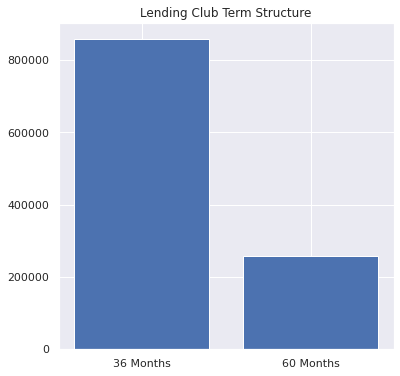

In [ ]:
sns.set(rc={'figure.figsize':(6,6)})
fig, ax = plt.subplots()
ax.bar(term_hist.index, term_hist.values)
plt.title("Lending Club Term Structure")
plt.show()

# Bond Amount Distribution

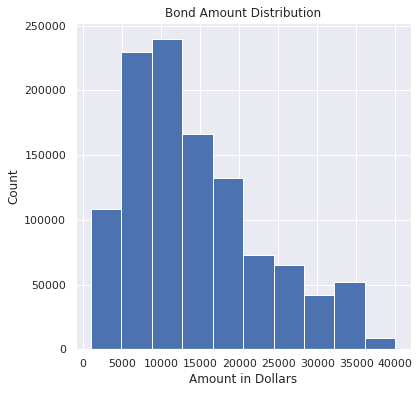

In [ ]:
sns.set(rc={'figure.figsize':(6,6)})
accepted["loan_amnt"].hist()
plt.title("Bond Amount Distribution")
plt.xlabel("Amount in Dollars")
plt.ylabel("Count")
plt.show()

# Issue Date Counts

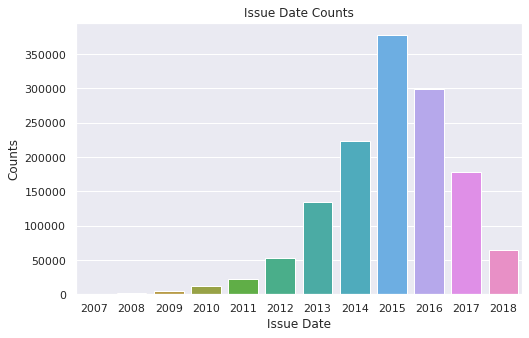

In [ ]:
sns.set(rc={'figure.figsize':(8,5)})
sns.barplot(x=accepted_ext.groupby('issue_y').count().index, y=accepted_ext.groupby('issue_y').count()['id'])
plt.title('Issue Date Counts')
plt.xlabel('Issue Date')
plt.ylabel('Counts')
plt.show()

# Counts of Loan Status

In [ ]:
accepted_ext['loan_status'] = accepted_ext['loan_status'].apply(lambda x: x if x[0:4] != 'Late' else 'Late')

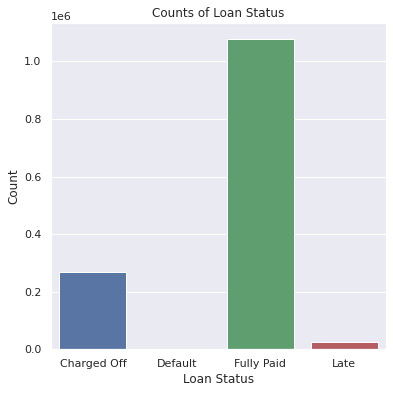

In [ ]:
sns.set(rc={'figure.figsize':(6,6)})
sns.barplot(x=accepted_ext.groupby('loan_status').count().index, y=accepted_ext.groupby('loan_status').count()['id'])
plt.xlabel('Loan Status')
plt.ylabel('Count')
plt.title('Counts of Loan Status')
plt.show()

# LendingClub Loan Grade Histogram

In [ ]:
grade_hist = accepted[["grade", "term"]].groupby("grade").count()

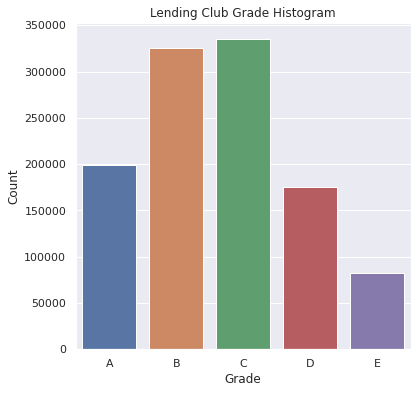

In [ ]:
sns.set(rc={'figure.figsize':(6,6)})
fig, ax = plt.subplots()
#colors = ["#005221","#90ee90", "#FFEF00", "#FFA400", "#F4364C"]
sns.barplot(x = grade_hist.index, y = grade_hist.term)
plt.title("Lending Club Grade Histogram")
plt.xlabel('Grade')
plt.ylabel('Count')
plt.show()

# Distribution of Interest Rate by Grade

In [ ]:
sns.set(rc={'figure.figsize':(6,6)})
index = 0 
kwargs = dict(alpha=0.7, bins=10, density=True, stacked=True)
colors = ["#005221","#90ee90", "#FFEF00", "#FFA400", "#F4364C"]
for i in sorted(accepted.grade.unique()):
  subset = accepted.loc[accepted.grade == i, ['int_rate']]
  plt.hist(subset['int_rate'], **kwargs, color = colors[index])
  index += 1
plt.xlabel("Interest Rate in %")
plt.ylabel("Probability")
plt.legend(["A","B","C","D","E"])
plt.title("Distribution of Interest Rate by Grade")
plt.show()

# Default Rates by Subgrade

In [ ]:
sns.set(rc={'figure.figsize':(6,6)})
from matplotlib.pyplot import figure
import matplotlib.ticker as mtick

figure(figsize=(15, 6), dpi=80)
plt.scatter(fully_paid.index, fully_paid.values, marker = "D")
plt.scatter(charged_off.index, charged_off.values, marker = "D")
plt.legend(["Fully Paid", "Charged Off"])
plt.xlabel("Subgrade Loan Status")
plt.ylabel("Percentage")
plt.title("Default Rates by Subgrade Loan")
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))

for key, val in enumerate(fully_paid):
    plt.text(key-0.5, val-0.05, str(round(val * 100,1)) + "%", color = "blue", fontsize = 8)
for key, val in enumerate(charged_off):
    plt.text(key-0.5, val+0.02, str(round(val * 100,1)) + "%", color = "orange", fontsize = 8)

plt.show()

# Expanding Mean of Default Rates by Loan

In [ ]:
loan_return_expanding = accepted[["date", "grade", "annual_return"]].sort_values("date", axis = 0)
loan_default_expanding = accepted[["date", "grade", "paid"]].sort_values("date", axis = 0)

In [ ]:
sns.set(rc={'figure.figsize':(6,6)})
fig, ax = plt.subplots(figsize = (8,3))

for i in sorted(loan_return_expanding.grade.unique()):
  subset = loan_default_expanding[loan_default_expanding.grade == i].copy()
  subset["expanding"] = 1 - subset["paid"].expanding().mean()
  ax.plot(subset["date"][150:], subset["expanding"][150:])
plt.legend(["A","B","C","D","E"])
plt.title("Expanding Mean of Default Rates by Loan")
plt.show()